# What Happens at the Cutoff of Pair Interactions? 

All models with short-ranged interactions need to cut them off somewhere. Something has to happen at that point. Usually you can either simply cut, cut and shift, or smooth the function.

We will use the Lennard-Jones pair potential as example.

In [1]:
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt 

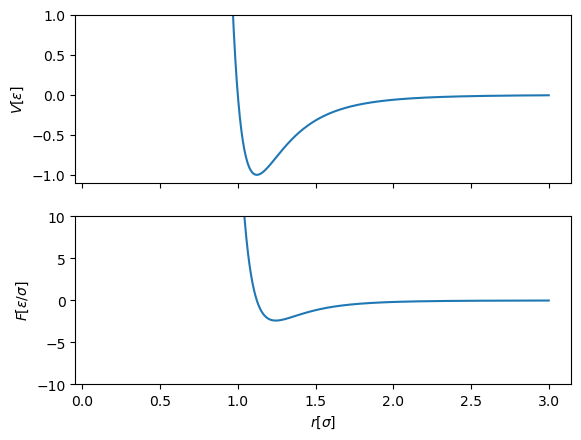

In [23]:
sigma = 1 
epsilon = 1
r_long = 3
r = np.linspace(0.1, r_long, 900)
V_lj = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
# F = - d/dr V 
# vec F_ij = F* vec r_ij
F_lj = -(-48*epsilon*sigma**12/r**13 + 24*epsilon*sigma**6/r**7)

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(r, V_lj)
ax[1].plot(r, F_lj)
ax[1].set_xlabel(r"$r[\sigma]$")
ax[0].set_ylabel(r"$V[\epsilon]$")
ax[1].set_ylabel(r"$F[\epsilon/\sigma]$")
ax[0].set_ylim([-1.1,1])
ax[1].set_ylim([-10,10])
plt.show()


## Truncate 

Simply cut the potential at the cutoff distance and set it to zero for larger distnaces.

- Truncation introduces a discontinuity in the potential energy.
- A sharp change in potential may result in nearly infinite forces:
    Technically, $\frac{d}{dx}(f(x) \theta(x - x_0)) = f(x) \delta(x - x_0) + f'(x) \theta(x - x_0)$ leads to the force having a "$\delta$-function jump" at the cutoff value $x_0$.
Most simulation packages avoid this issue by setting the cutoff to be if $x\geq x_0$ then the force is set to $F=0$.


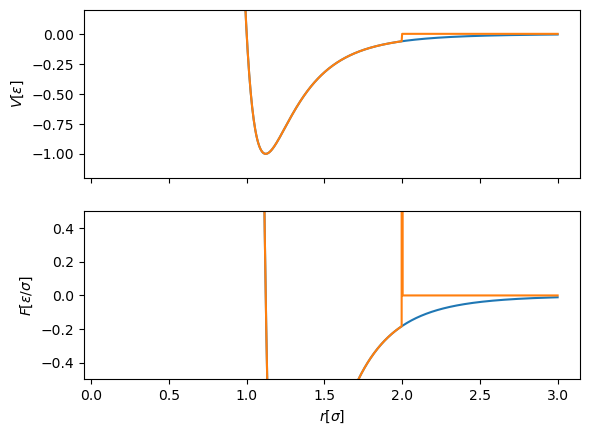

In [122]:
r_cut_short = 2.0
V_lj_cut = np.piecewise(r, [r < r_cut_short,r >=r_cut_short], [lambda x: 4*epsilon*((sigma/x)**12 - (sigma/x)**6), 0])  
# F = - d/dr V 
# vec F_ij = F* vec r_ij
F_lj_cut = np.piecewise(r, [r < r_cut_short, np.isclose(r,r_cut_short), r > r_cut_short], 
[lambda x: -(-48*epsilon*sigma**12/x**13 + 24*epsilon*sigma**6/x**7),100,0.0])

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(r, V_lj)
ax[1].plot(r, F_lj)
ax[0].plot(r, V_lj_cut)
ax[1].plot(r, F_lj_cut)
ax[1].set_xlabel(r"$r[\sigma]$")
ax[0].set_ylabel(r"$V[\epsilon]$")
ax[1].set_ylabel(r"$F[\epsilon/\sigma]$")
ax[0].set_ylim([-1.2,0.2])
ax[1].set_ylim([-0.5,0.5])
plt.show()


Note that a cutoff of 2 is unreasonably short for any "real" simulation, the jump is too large to be functional for MD (but could be done in MC). 

## Truncate and Shift 

We could also cut and then shift the function up such that it is zero at the cutoff. This works, note however, that the force is unaffected by this. Also, this does shift the entire potential up everywhere, meaning that energies at the minium (and consequently total energies, phase boundaries, critical points, etc,... ) are different!

Shift the whole potential uniformly by adding a constant at values below cutoff.
- Avoids infinite forces.
- Does not change forces at the distances below cutoff.
- Introduces a discontinuity in the force at the cutoff distance.
- Modifies total potential energy.


Technically you have change the Hamiltionian of the system to a different one. This might be fine and acceptable for your problem, or not. 

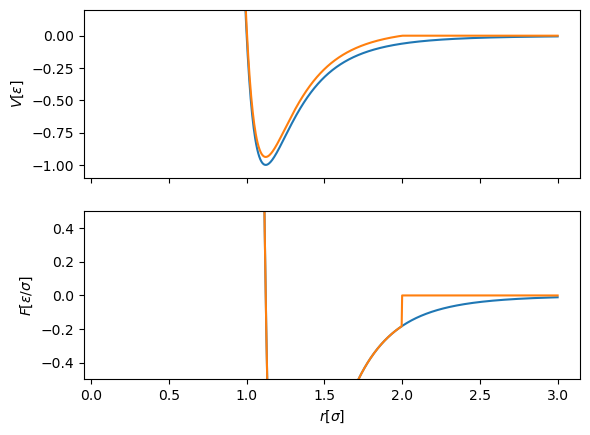

In [114]:
r_cut_short = 2.0
V_lj_cut_and_shift = np.piecewise(r, [r < r_cut_short,r >=r_cut_short], 
                                  [lambda x: 4*epsilon*((sigma/x)**12 - (sigma/x)**6) 
                                   - 4*epsilon*((sigma/r_cut_short)**12 - (sigma/r_cut_short)**6), 0])  
# F = - d/dr V 
# vec F_ij = F* vec r_ij
F_lj_cut_and_shift = np.piecewise(r, [r < r_cut_short, r >= r_cut_short], 
[lambda x: -(-48*epsilon*sigma**12/x**13 + 24*epsilon*sigma**6/x**7),0])

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(r, V_lj)
ax[1].plot(r, F_lj)
ax[0].plot(r, V_lj_cut_and_shift)
ax[1].plot(r, F_lj_cut_and_shift)
ax[1].set_xlabel(r"$r[\sigma]$")
ax[0].set_ylabel(r"$V[\epsilon]$")
ax[1].set_ylabel(r"$F[\epsilon/\sigma]$")
ax[0].set_ylim([-1.1,0.2])
ax[1].set_ylim([-0.5,0.5])
plt.show()


## Smoothing

Alternatively, if the potential shape and energy scale should be preserved, one can smooth the potential with a function $S(x)$ close to the cutoff such that it goes to zero without changing the rest of the function. 

For the force it means then we need to compute: 

$\frac{d}{dx}(V(x) S(x)) = S(x) F(x) - V(x) S'(x)$ (note the mystery "-", this is copied from HOOMD-blue source code)

LAMMPS has a different smoothing approach: https://docs.lammps.org/pair_lj_smooth.html They smooth the force, causing the enrgy to be discontinous 


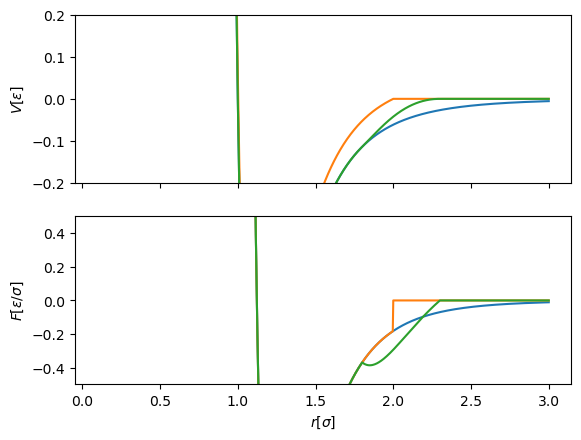

In [118]:
r_on_xplor = 1.8
r_cut_xplor = 2.3 
xplor_smoothing_function = np.piecewise(r, [r < r_on_xplor,(r>=r_on_xplor) & (r<r_cut_xplor),r >=r_cut_xplor], 
                                  [1,lambda x: (x**2-r_cut_xplor**2)**2*(r_cut_xplor**2+2*x**2-3*r_on_xplor**2)/(r_cut_xplor**2-r_on_xplor**2)**3, 0])  

#(12 x (a^2 - x^2) (b^2 - x^2))/(a^2 - b^2)^3
dxplor_smoothing_function = np.piecewise(r, [r < r_on_xplor,(r>=r_on_xplor) & (r<r_cut_xplor),r >=r_cut_xplor], 
                                  [0,lambda x:(12*x*(x**2 - r_cut_xplor**2)*(x**2-r_on_xplor**2))/(r_cut_xplor**2 - r_on_xplor**2)**3,0])
V_lj_smooth = V_lj*xplor_smoothing_function
# F = - d/dr V 
# vec F_ij = F* vec r_ij
F_lj_smooth = (-V_lj*dxplor_smoothing_function +F_lj*xplor_smoothing_function)

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(r, V_lj)
ax[1].plot(r, F_lj)
ax[0].plot(r, V_lj_cut_and_shift)
ax[1].plot(r, F_lj_cut_and_shift)
ax[0].plot(r, V_lj_smooth)
ax[1].plot(r, F_lj_smooth)
ax[1].set_xlabel(r"$r[\sigma]$")
ax[0].set_ylabel(r"$V[\epsilon]$")
ax[1].set_ylabel(r"$F[\epsilon/\sigma]$")
ax[0].set_ylim([-0.2,0.2])
ax[1].set_ylim([-0.5,0.5])
plt.show()


## Check with HOOMD-blue

We can use HOOMD-blue (or any other simulation package you are interested in) to test how they handle cutoff options. Define a small test simulation with two particles only, set them at fixed distances and compute the energies and forces. This is a good test to figure out if you understood the pair potential setup and options correctly!

LAMMPS offers the convinient ``pair_write`` command to do this: https://docs.lammps.org/pair_write.html

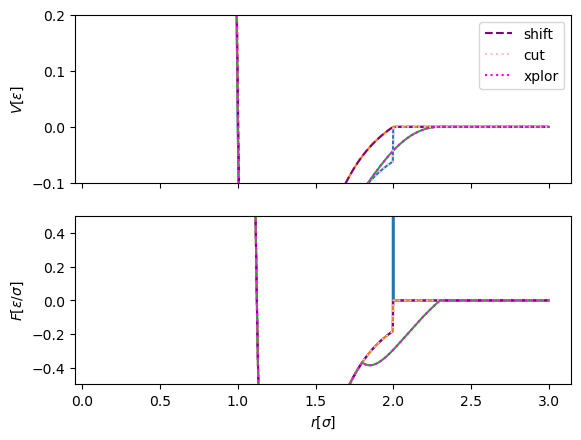

In [123]:
import gsd,gsd.hoomd 
import hoomd 

frame = gsd.hoomd.Frame()

frame.particles.N = 2
frame.particles.position = [[0,0,0],[3.0,0,0]]
frame.configuration.box = [10, 10, 10, 0, 0, 0]
frame.particles.types = ['A']

integrator = hoomd.md.Integrator(dt=0) 
cell = hoomd.md.nlist.Cell(buffer=0.4)

LJ_cut = hoomd.md.pair.LJ(nlist=cell)
LJ_cut.params[("A", "A")] = dict(epsilon=epsilon, sigma=sigma)
LJ_cut.r_cut[("A", "A")] = 2.0
LJ_cut.mode = "none"

LJ_shift = hoomd.md.pair.LJ(nlist=cell)
LJ_shift.params[("A", "A")] = dict(epsilon=epsilon, sigma=sigma)
LJ_shift.r_cut[("A", "A")] = 2.0
LJ_shift.mode = "shift"

LJ_xplor = hoomd.md.pair.LJ(nlist=cell)
LJ_xplor.params[("A", "A")] = dict(epsilon=epsilon, sigma=sigma)
LJ_xplor.r_cut[("A", "A")] = 2.3
LJ_xplor.r_on[("A", "A")] = 1.8
LJ_xplor.mode = "xplor"

integrator.forces = [LJ_cut,LJ_shift,LJ_xplor]


simulation = hoomd.Simulation(device=hoomd.device.auto_select())
simulation.operations.integrator = integrator 

simulation.create_state_from_snapshot(frame) 


measured_energy_shift = []
measured_forces_shift = [] 
measured_energy_cut = []
measured_forces_cut = [] 
measured_energy_xplor = []
measured_forces_xplor = [] 
for a in r: 
    snapshot = simulation.state.get_snapshot()
    snapshot.particles.position[1] = [a,0,0] 
    simulation.state.set_snapshot(snapshot)
    
    simulation.run(0)

    measured_energy_shift.append(LJ_shift.energy)
    measured_forces_shift.append(LJ_shift.forces[1,0])
    measured_energy_cut.append(LJ_cut.energy)
    measured_forces_cut.append(LJ_cut.forces[1,0])
    measured_energy_xplor.append(LJ_xplor.energy)
    measured_forces_xplor.append(LJ_xplor.forces[1,0])


fig, ax = matplotlib.pyplot.subplots(2,1,sharex=True)

ax[0].plot(r, V_lj_cut)
ax[0].plot(r, V_lj_cut_and_shift)
ax[0].plot(r, V_lj_smooth)
ax[0].plot(r, measured_energy_shift,linestyle='dashed',c='purple',label='shift')
ax[0].plot(r, measured_energy_cut,linestyle='dotted',c='pink',label='cut')
ax[0].plot(r, measured_energy_xplor,linestyle='dotted',c='magenta',label='xplor')


ax[1].plot(r, F_lj_cut)
ax[1].plot(r, F_lj_cut_and_shift)
ax[1].plot(r, F_lj_smooth)
ax[1].plot(r, measured_forces_shift,linestyle='dashed',c='purple')
ax[1].plot(r, measured_forces_cut,linestyle='dotted',c='pink')
ax[1].plot(r, measured_forces_xplor,linestyle='dotted',c='magenta')

ax[0].legend()
ax[1].set_xlabel(r"$r[\sigma]$")
ax[0].set_ylabel(r"$V[\epsilon]$")
ax[1].set_ylabel(r"$F[\epsilon/\sigma]$")
#ax[0].set_ylim([-1.1,0.5])
#ax[1].set_ylim([-3,1])
#ax[1].set_xlim([0.99,2.5])
ax[0].set_ylim([-0.1,0.2])
ax[1].set_ylim([-0.5,0.5])
matplotlib.pyplot.show()

It is best to: 
1. carefully consider what is important for the simulation at hand:
    2. Energy "jumps" in the potential energy if the energy doesn't go to zero smoothly at the cutoff  
    3. Artificial force discontinuity at the truncation can lead to "jumps" in kinetic energy
    4. Shifting changes the minimum value (i.e the value at the most probable distance) of the potential - changes properties
2. **keep the cutoff reasonably "large". Typically this is about 3.0 for LJ**
3. see if "tail corrections" might be neccessary for thermodynamic quantities to match with theory